## Import

In [6]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

## Load Data / Normalize

In [7]:
# load data and normalize it
background = np.load('background.npz')['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)

bbh = np.load('bbh_for_challenge.npy')
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)

sglf = np.load('sglf_for_challenge.npy')
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
sglf = sglf/stds
sglf = np.swapaxes(sglf, 1, 2)

## Train / Test Splits

x_train, x_test, y_train, y_test = train_test_split(
     background, background, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

In [13]:
combined_data = np.concatenate([background, bbh, sglf], axis=0)
combined_labels = np.concatenate([
    np.zeros(len(background)),  # Label 0: background
    np.zeros(len(bbh)),         # Label 0: BBH (non-anomalous)
    np.ones(len(sglf))          # Label 1: SGLF (anomalous)
])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    combined_data, combined_labels, test_size=0.2, random_state=42
)

##3 thing


## Autoencoder

In [14]:
def create_autoencoder(input_shape, latent_dim=16):
    inputs = tf.keras.Input(shape=input_shape)
    # Encoder
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu', name="latent_space")(x)
    
    # Decoder
    x = layers.Dense((input_shape[0] // 4) * 64, activation='relu')(latent)
    x = layers.Reshape((input_shape[0] // 4, 64))(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    decoded = layers.Conv1D(input_shape[-1], kernel_size=3, activation='sigmoid', padding='same')(x)
    
    # Autoencoder
    autoencoder = tf.keras.Model(inputs, decoded)
    encoder = tf.keras.Model(inputs, latent)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Create and train autoencoder
autoencoder, encoder = create_autoencoder(X_train.shape[1:], latent_dim=16)
autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/50


2025-01-12 02:56:20.364429: W external/local_xla/xla/service/gpu/triton_autotuner.cc:660] Compiling 42 configs for 2 fusions on a single thread.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.0077 - val_loss: 1.0008
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.9999 - val_loss: 0.9970
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.9968 - val_loss: 0.9966
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.9957 - val_loss: 0.9876
Epoch 5/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.9873 - val_loss: 0.9871
Epoch 6/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.9868 - val_loss: 0.9868
Epoch 7/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.9866 - val_loss: 0.9867
Epoch 8/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.9865 - val_loss: 0.9866
Epoch 9/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.9864 - val_loss: 0.9865
Epoch 10/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.9863 - val_loss: 0.9867
Epoch 11/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.9861 - val_loss: 0.9863
Epoch 12/50
3000/3000 ━━━━━━━━

## Kmeans

In [5]:
from sklearn.cluster import KMeans

# Extract latent features
latent_features = encoder.predict(X_train)

# Apply K-Means
n_clusters = 2  # One for normal, one for anomalies
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(latent_features)

# Compute cluster distances
cluster_distances = kmeans.transform(latent_features)  # Distance to cluster centers


NameError: name 'encoder' is not defined

## Neural Network

In [16]:
# Compute reconstruction errors
reconstructed_data = autoencoder.predict(X_train)
reconstruction_errors = np.mean((reconstructed_data - X_train) ** 2, axis=(1, 2))

# Combine features for anomaly detection
features = np.stack([reconstruction_errors, cluster_distances.min(axis=1)], axis=1)

# Neural network for anomaly probability
nn_model = tf.keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(2,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output: anomaly probability
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
nn_model.fit(features, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate on the test set
latent_test_features = encoder.predict(X_test)
test_reconstructed = autoencoder.predict(X_test)
test_reconstruction_errors = np.mean((test_reconstructed - X_test) ** 2, axis=(1, 2))
test_cluster_distances = kmeans.transform(latent_test_features).min(axis=1)

test_features = np.stack([test_reconstruction_errors, test_cluster_distances], axis=1)
test_predictions = nn_model.predict(test_features)

# Print anomaly probabilities
print("Anomaly probabilities (first 10):", test_predictions[:10].flatten())


2025-01-12 03:05:14.236461: W external/local_xla/xla/service/gpu/triton_autotuner.cc:656] Compiling 18 configs for triton_gemm_dot.69 on a single thread.


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Epoch 1/20


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-12 03:05:36.071569: W external/local_xla/xla/service/gpu/triton_autotuner.cc:660] Compiling 4 configs for 2 fusions on a single thread.


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.6553 - loss: 0.6358 - val_accuracy: 0.6679 - val_loss: 0.6268
Epoch 2/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.6664 - loss: 0.6276 - val_accuracy: 0.6679 - val_loss: 0.6249
Epoch 3/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6652 - loss: 0.6260 - val_accuracy: 0.6679 - val_loss: 0.6267
Epoch 4/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6678 - loss: 0.6227 - val_accuracy: 0.6679 - val_loss: 0.6193
Epoch 5/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6679 - loss: 0.6173 - val_accuracy: 0.6668 - val_loss: 0.6154
Epoch 6/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6661 - loss: 0.6137 - val_accuracy: 0.6678 - val_loss: 0.6124
Epoch 7/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6649 - loss: 0.6113 - val_accuracy: 0.6663 - val_loss: 0.6076
Epoch 8/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6648 - loss: 0.6064 - val_a

In [ ]:
test_predictions


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 794us/step


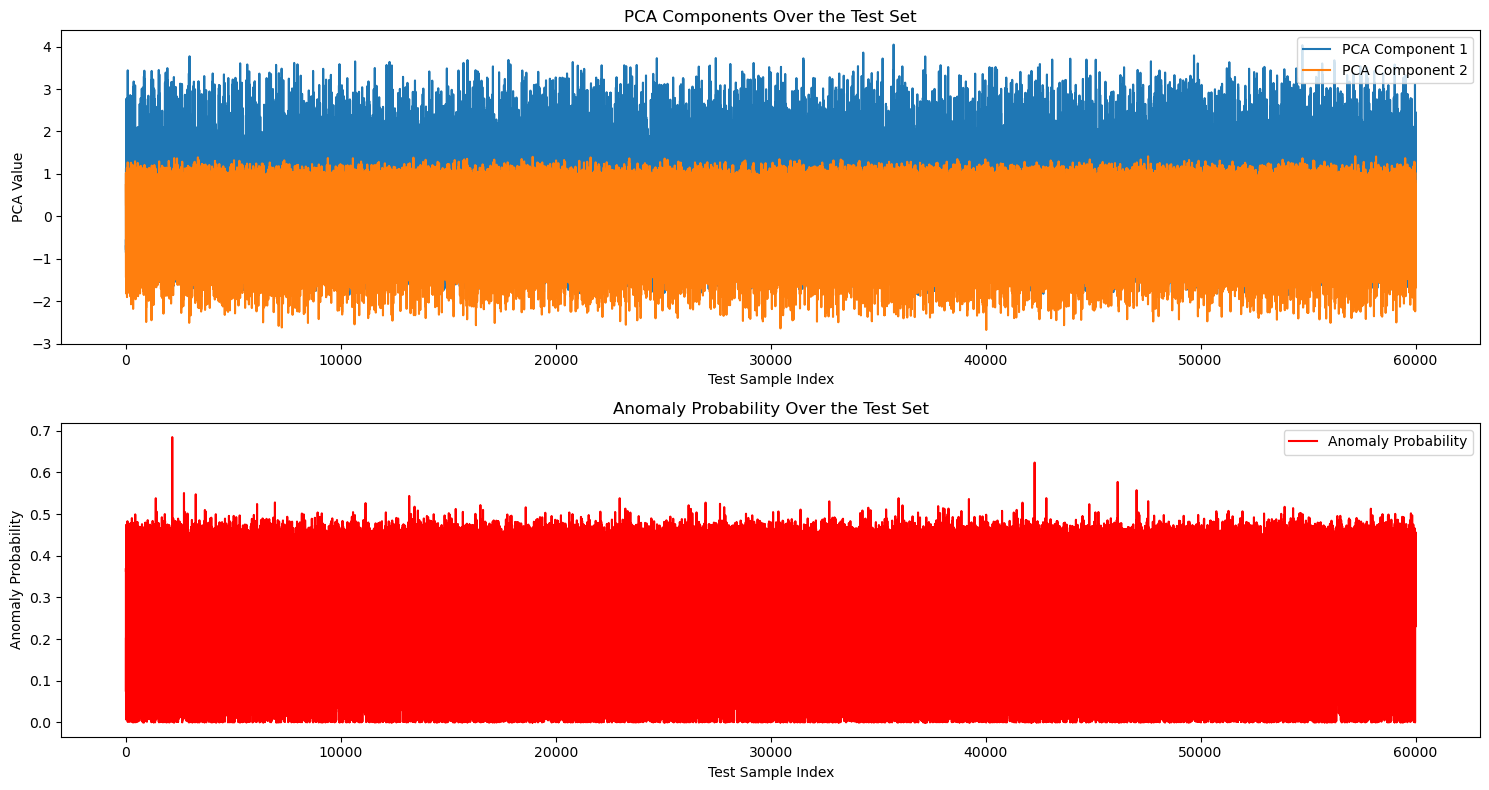

In [22]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Reduce Latent Features to 2D using PCA
latent_test_features = encoder.predict(X_test)  # Extract latent features from encoder
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_test_features)

# Step 2: Plot PCA Components and Anomaly Probabilities
def plot_pca_and_anomalies(pca_components, probabilities):
    plt.figure(figsize=(15, 8))

    # Plot PCA Components
    plt.subplot(2, 1, 1)
    plt.plot(pca_components[:, 0], label="PCA Component 1")
    plt.plot(pca_components[:, 1], label="PCA Component 2")
    plt.title("PCA Components Over the Test Set")
    plt.xlabel("Test Sample Index")
    plt.ylabel("PCA Value")
    plt.legend()

    # Plot Anomaly Probabilities
    plt.subplot(2, 1, 2)
    plt.plot(probabilities, 'r-', label="Anomaly Probability")
    plt.title("Anomaly Probability Over the Test Set")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Anomaly Probability")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to visualize
plot_pca_and_anomalies(latent_2d, test_predictions.flatten())


In [26]:
def calculate_anomaly_percentages(data, model, threshold):
    # Extract latent features
    latent_features = encoder.predict(data)
    
    # Compute reconstruction errors
    reconstructed_data = autoencoder.predict(data)
    reconstruction_errors = np.mean((reconstructed_data - data) ** 2, axis=(1, 2))
    
    # Compute cluster distances
    cluster_distances = kmeans.transform(latent_features).min(axis=1)
    
    # Combine features
    features = np.stack([reconstruction_errors, cluster_distances], axis=1)
    
    # Predict anomaly probabilities
    anomaly_probabilities = model.predict(features).flatten()
    
    # Flag samples as anomalous based on threshold
    flagged_anomalous = anomaly_probabilities > threshold
    percentage_anomalous = np.sum(flagged_anomalous) / len(data) * 100
    
    return percentage_anomalous, flagged_anomalous

# Define threshold for anomaly probability
anomaly_threshold = 0.5  # Adjust based on your use case

# Calculate anomaly percentages for each dataset
background_anomalous_percentage, background_flags = calculate_anomaly_percentages(background, nn_model, anomaly_threshold)
bbh_anomalous_percentage, bbh_flags = calculate_anomaly_percentages(bbh, nn_model, anomaly_threshold)
sglf_anomalous_percentage, sglf_flags = calculate_anomaly_percentages(sglf, nn_model, anomaly_threshold)

# Print results
print(f"Percentage of Background flagged as anomalous: {background_anomalous_percentage:.2f}%")
print(f"Percentage of BBH flagged as anomalous: {bbh_anomalous_percentage:.2f}%")
print(f"Percentage of SGLF flagged as anomalous: {sglf_anomalous_percentage:.2f}%")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 800us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 944us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 925us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 790us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 928us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 719us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 793us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 923us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 723us/step
Percentage of Background flagged as anomalous: 0.17%
Percentage of BBH flagged as anomalous: 0.13%
Percentage of SGLF flagged as anomalous: 0.18%
